## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  val_last_windowsize = val_data[-window_size:]
  test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

  train_windows, train_targets = create_dataset(train_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)
  test_windows, test_targets = create_dataset(test_data_extended, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-17 01:52:30,105] A new study created in memory with name: no-name-689dab65-394d-4d21-8676-c123cfca4a5f


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:52:43,747] Trial 0 finished with value: 19.9534804320609 and parameters: {'window_size': 56, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.11421263737433468, 'attention_dim': 12}. Best is trial 0 with value: 19.9534804320609.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:52:53,762] Trial 1 finished with value: 8.056511549986164 and parameters: {'window_size': 66, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.46134143984942755, 'attention_dim': 20}. Best is trial 1 with value: 8.056511549986164.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:52:57,536] Trial 2 finished with value: 28.31602591249263 and parameters: {'window_size': 99, 'tcn_filters': 46, 'tcn_kernel_size': 5, 'dropout_rate': 0.24107304140329813, 'attention_dim': 17}. Best is trial 1 with value: 8.056511549986164.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:53:03,907] Trial 3 finished with value: 6.816185953966694 and parameters: {'window_size': 47, 'tcn_filters': 73, 'tcn_kernel_size': 3, 'dropout_rate': 0.30781045528264084, 'attention_dim': 15}. Best is trial 3 with value: 6.816185953966694.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:53:09,961] Trial 4 finished with value: 7.658873668848503 and parameters: {'window_size': 74, 'tcn_filters': 42, 'tcn_kernel_size': 3, 'dropout_rate': 0.26008008152528556, 'attention_dim': 24}. Best is trial 3 with value: 6.816185953966694.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:53:22,042] Trial 5 finished with value: 6.266867906745552 and parameters: {'window_size': 88, 'tcn_filters': 122, 'tcn_kernel_size': 2, 'dropout_rate': 0.1277712351590893, 'attention_dim': 18}. Best is trial 5 with value: 6.266867906745552.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:53:28,413] Trial 6 finished with value: 9.026373363721733 and parameters: {'window_size': 77, 'tcn_filters': 37, 'tcn_kernel_size': 4, 'dropout_rate': 0.13895824467684142, 'attention_dim': 18}. Best is trial 5 with value: 6.266867906745552.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:53:35,255] Trial 7 finished with value: 6.716393278343607 and parameters: {'window_size': 74, 'tcn_filters': 90, 'tcn_kernel_size': 3, 'dropout_rate': 0.2814902575508243, 'attention_dim': 26}. Best is trial 5 with value: 6.266867906745552.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:53:44,127] Trial 8 finished with value: 7.610750118802967 and parameters: {'window_size': 47, 'tcn_filters': 79, 'tcn_kernel_size': 5, 'dropout_rate': 0.1891575523839436, 'attention_dim': 11}. Best is trial 5 with value: 6.266867906745552.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:53:47,918] Trial 9 finished with value: 21.756207177764153 and parameters: {'window_size': 36, 'tcn_filters': 49, 'tcn_kernel_size': 3, 'dropout_rate': 0.14949281578137696, 'attention_dim': 29}. Best is trial 5 with value: 6.266867906745552.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:53:51,485] Trial 10 finished with value: 4.762973600978338 and parameters: {'window_size': 14, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.35687967638757145, 'attention_dim': 8}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:53:56,287] Trial 11 finished with value: 5.899723770316905 and parameters: {'window_size': 10, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.3489808802129577, 'attention_dim': 8}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 1s 2ms/step


[I 2023-06-17 01:53:59,321] Trial 12 finished with value: 11.151887435686852 and parameters: {'window_size': 10, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.36655017155591485, 'attention_dim': 9}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:54:03,122] Trial 13 finished with value: 6.761045288670383 and parameters: {'window_size': 11, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.38579753280737655, 'attention_dim': 8}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:54:08,259] Trial 14 finished with value: 6.506845128719159 and parameters: {'window_size': 22, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.352892530261968, 'attention_dim': 14}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:54:13,923] Trial 15 finished with value: 5.886352023536679 and parameters: {'window_size': 27, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.4276931761485567, 'attention_dim': 11}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:54:25,336] Trial 16 finished with value: 10.101252315942313 and parameters: {'window_size': 30, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.44072277579694963, 'attention_dim': 12}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:54:29,116] Trial 17 finished with value: 23.584270694785964 and parameters: {'window_size': 24, 'tcn_filters': 68, 'tcn_kernel_size': 3, 'dropout_rate': 0.48017121849288746, 'attention_dim': 23}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:54:35,874] Trial 18 finished with value: 6.718093240006745 and parameters: {'window_size': 33, 'tcn_filters': 59, 'tcn_kernel_size': 2, 'dropout_rate': 0.4218977046437693, 'attention_dim': 32}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:54:42,219] Trial 19 finished with value: 12.76466421721832 and parameters: {'window_size': 21, 'tcn_filters': 92, 'tcn_kernel_size': 3, 'dropout_rate': 0.4052441304255098, 'attention_dim': 14}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:54:53,732] Trial 20 finished with value: 7.358595697780094 and parameters: {'window_size': 42, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.4964309432987093, 'attention_dim': 10}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:54:57,554] Trial 21 finished with value: 12.160436196446495 and parameters: {'window_size': 16, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.34051190135400033, 'attention_dim': 9}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:55:05,073] Trial 22 finished with value: 8.58088541828595 and parameters: {'window_size': 26, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.4195735306631548, 'attention_dim': 8}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 01:55:09,686] Trial 23 finished with value: 9.981837187438359 and parameters: {'window_size': 16, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.32536355080812707, 'attention_dim': 12}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:55:12,808] Trial 24 finished with value: 15.098345945862766 and parameters: {'window_size': 10, 'tcn_filters': 113, 'tcn_kernel_size': 3, 'dropout_rate': 0.39266705166820093, 'attention_dim': 8}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:55:19,989] Trial 25 finished with value: 4.863792103569037 and parameters: {'window_size': 39, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.3762696828690815, 'attention_dim': 15}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:55:26,440] Trial 26 finished with value: 16.947158888241216 and parameters: {'window_size': 39, 'tcn_filters': 83, 'tcn_kernel_size': 3, 'dropout_rate': 0.44794630735010876, 'attention_dim': 16}. Best is trial 10 with value: 4.762973600978338.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:55:38,393] Trial 27 finished with value: 4.7129178166065016 and parameters: {'window_size': 52, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.38032290446171313, 'attention_dim': 14}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:55:50,762] Trial 28 finished with value: 7.606517736328551 and parameters: {'window_size': 59, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.37554257668161317, 'attention_dim': 20}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:56:01,805] Trial 29 finished with value: 5.799640301665046 and parameters: {'window_size': 52, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.3159029142583243, 'attention_dim': 13}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:56:07,566] Trial 30 finished with value: 8.50200686419159 and parameters: {'window_size': 55, 'tcn_filters': 84, 'tcn_kernel_size': 2, 'dropout_rate': 0.3924492618199537, 'attention_dim': 15}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:56:18,317] Trial 31 finished with value: 6.974115667497218 and parameters: {'window_size': 60, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.3179380451169173, 'attention_dim': 14}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:56:29,865] Trial 32 finished with value: 8.239027773944565 and parameters: {'window_size': 51, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.362458363525754, 'attention_dim': 13}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:56:41,420] Trial 33 finished with value: 4.792739758918472 and parameters: {'window_size': 65, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.3315062823433476, 'attention_dim': 19}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:57:03,306] Trial 34 finished with value: 10.052951636055106 and parameters: {'window_size': 66, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.3369895661038105, 'attention_dim': 21}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:57:16,613] Trial 35 finished with value: 6.575754908087122 and parameters: {'window_size': 62, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.2921531443912059, 'attention_dim': 17}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:57:25,442] Trial 36 finished with value: 4.936133190779458 and parameters: {'window_size': 82, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.3720025754839934, 'attention_dim': 20}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:57:40,102] Trial 37 finished with value: 6.299776818839665 and parameters: {'window_size': 68, 'tcn_filters': 106, 'tcn_kernel_size': 5, 'dropout_rate': 0.3041653646270626, 'attention_dim': 19}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 01:57:51,650] Trial 38 finished with value: 5.352130356063863 and parameters: {'window_size': 46, 'tcn_filters': 88, 'tcn_kernel_size': 3, 'dropout_rate': 0.2758373295069192, 'attention_dim': 22}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:58:03,141] Trial 39 finished with value: 8.061233665303718 and parameters: {'window_size': 90, 'tcn_filters': 75, 'tcn_kernel_size': 2, 'dropout_rate': 0.3304595267988163, 'attention_dim': 25}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:58:09,535] Trial 40 finished with value: 15.273070149600079 and parameters: {'window_size': 42, 'tcn_filters': 120, 'tcn_kernel_size': 3, 'dropout_rate': 0.4021223659440675, 'attention_dim': 16}. Best is trial 27 with value: 4.7129178166065016.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:58:21,360] Trial 41 finished with value: 4.706089217058409 and parameters: {'window_size': 82, 'tcn_filters': 98, 'tcn_kernel_size': 2, 'dropout_rate': 0.37669978213998234, 'attention_dim': 19}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:58:33,063] Trial 42 finished with value: 8.164169704374237 and parameters: {'window_size': 89, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.354483082321077, 'attention_dim': 18}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:58:42,730] Trial 43 finished with value: 6.658325772150692 and parameters: {'window_size': 94, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.38347100996705613, 'attention_dim': 17}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:58:52,807] Trial 44 finished with value: 5.240541990523108 and parameters: {'window_size': 82, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.3583921445416219, 'attention_dim': 19}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 01:59:04,867] Trial 45 finished with value: 4.778460499196799 and parameters: {'window_size': 74, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.3373422638316212, 'attention_dim': 22}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:59:15,402] Trial 46 finished with value: 5.90033504693064 and parameters: {'window_size': 70, 'tcn_filters': 121, 'tcn_kernel_size': 2, 'dropout_rate': 0.30530987220163963, 'attention_dim': 27}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:59:23,452] Trial 47 finished with value: 6.846959971719792 and parameters: {'window_size': 77, 'tcn_filters': 107, 'tcn_kernel_size': 3, 'dropout_rate': 0.3370868228140084, 'attention_dim': 22}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 01:59:32,150] Trial 48 finished with value: 7.32657739082246 and parameters: {'window_size': 100, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.34812482114873433, 'attention_dim': 24}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 01:59:43,647] Trial 49 finished with value: 5.617792943761671 and parameters: {'window_size': 73, 'tcn_filters': 106, 'tcn_kernel_size': 5, 'dropout_rate': 0.26757519355574716, 'attention_dim': 21}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 02:00:05,399] Trial 50 finished with value: 7.080520962023877 and parameters: {'window_size': 80, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.3170223345783831, 'attention_dim': 19}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:00:17,206] Trial 51 finished with value: 8.109907074961056 and parameters: {'window_size': 84, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.37278267468320136, 'attention_dim': 16}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:00:23,991] Trial 52 finished with value: 4.889850408438872 and parameters: {'window_size': 63, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.40950575850218146, 'attention_dim': 18}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:00:34,520] Trial 53 finished with value: 4.782015013533815 and parameters: {'window_size': 71, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.3846770283648555, 'attention_dim': 11}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 02:00:46,549] Trial 54 finished with value: 4.929314432245028 and parameters: {'window_size': 71, 'tcn_filters': 92, 'tcn_kernel_size': 2, 'dropout_rate': 0.36050796377923977, 'attention_dim': 11}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:00:52,965] Trial 55 finished with value: 6.1957297408448015 and parameters: {'window_size': 78, 'tcn_filters': 81, 'tcn_kernel_size': 2, 'dropout_rate': 0.39615979437759374, 'attention_dim': 10}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:01:00,182] Trial 56 finished with value: 12.535684561330953 and parameters: {'window_size': 66, 'tcn_filters': 89, 'tcn_kernel_size': 2, 'dropout_rate': 0.3429992185960465, 'attention_dim': 10}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:01:06,013] Trial 57 finished with value: 10.056150160300918 and parameters: {'window_size': 75, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.387700609156569, 'attention_dim': 9}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:01:14,585] Trial 58 finished with value: 5.065452392592439 and parameters: {'window_size': 57, 'tcn_filters': 110, 'tcn_kernel_size': 3, 'dropout_rate': 0.3311009362907302, 'attention_dim': 24}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:01:19,725] Trial 59 finished with value: 8.75081926778881 and parameters: {'window_size': 85, 'tcn_filters': 76, 'tcn_kernel_size': 4, 'dropout_rate': 0.41520565194516373, 'attention_dim': 27}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 02:01:29,025] Trial 60 finished with value: 7.8258966278880875 and parameters: {'window_size': 96, 'tcn_filters': 55, 'tcn_kernel_size': 2, 'dropout_rate': 0.29118340179903357, 'attention_dim': 12}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:01:40,497] Trial 61 finished with value: 4.968980693477391 and parameters: {'window_size': 70, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.3789066138241989, 'attention_dim': 13}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 02:01:47,438] Trial 62 finished with value: 21.772898553929373 and parameters: {'window_size': 64, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.3720131688775055, 'attention_dim': 15}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 02:01:53,955] Trial 63 finished with value: 11.934903533489047 and parameters: {'window_size': 34, 'tcn_filters': 67, 'tcn_kernel_size': 2, 'dropout_rate': 0.34982291029498414, 'attention_dim': 11}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 02:01:57,705] Trial 64 finished with value: 11.789116595407757 and parameters: {'window_size': 53, 'tcn_filters': 32, 'tcn_kernel_size': 2, 'dropout_rate': 0.4340167360850111, 'attention_dim': 21}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-17 02:02:09,185] Trial 65 finished with value: 6.476803205214787 and parameters: {'window_size': 46, 'tcn_filters': 103, 'tcn_kernel_size': 2, 'dropout_rate': 0.3998416460374566, 'attention_dim': 17}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 2ms/step


[I 2023-06-17 02:02:15,522] Trial 66 finished with value: 7.274593182456463 and parameters: {'window_size': 20, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.35949683894553214, 'attention_dim': 15}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:02:27,062] Trial 67 finished with value: 4.783167438785576 and parameters: {'window_size': 75, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.37930266572059834, 'attention_dim': 9}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:02:38,574] Trial 68 finished with value: 4.822111479066619 and parameters: {'window_size': 75, 'tcn_filters': 111, 'tcn_kernel_size': 2, 'dropout_rate': 0.40923165752008384, 'attention_dim': 8}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:03:00,492] Trial 69 finished with value: 5.32124383882893 and parameters: {'window_size': 72, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.32740857823047337, 'attention_dim': 9}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-17 02:03:12,919] Trial 70 finished with value: 33.225984925544005 and parameters: {'window_size': 85, 'tcn_filters': 123, 'tcn_kernel_size': 3, 'dropout_rate': 0.42692443904303146, 'attention_dim': 10}. Best is trial 41 with value: 4.706089217058409.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:03:24,437] Trial 71 finished with value: 4.621401782894181 and parameters: {'window_size': 75, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.41284166784834714, 'attention_dim': 8}. Best is trial 71 with value: 4.621401782894181.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:03:33,969] Trial 72 finished with value: 7.260119663916523 and parameters: {'window_size': 68, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.3851503373242948, 'attention_dim': 8}. Best is trial 71 with value: 4.621401782894181.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:03:55,735] Trial 73 finished with value: 4.489363875168034 and parameters: {'window_size': 81, 'tcn_filters': 113, 'tcn_kernel_size': 2, 'dropout_rate': 0.3937049480702521, 'attention_dim': 9}. Best is trial 73 with value: 4.489363875168034.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:04:06,793] Trial 74 finished with value: 8.05686656333439 and parameters: {'window_size': 81, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.4169475865169956, 'attention_dim': 9}. Best is trial 73 with value: 4.489363875168034.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 02:04:19,311] Trial 75 finished with value: 4.896497774589458 and parameters: {'window_size': 92, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.36697014407445244, 'attention_dim': 9}. Best is trial 73 with value: 4.489363875168034.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:04:31,108] Trial 76 finished with value: 4.555900615255916 and parameters: {'window_size': 87, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.3947906685812063, 'attention_dim': 12}. Best is trial 73 with value: 4.489363875168034.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:04:52,957] Trial 77 finished with value: 4.421581524750776 and parameters: {'window_size': 78, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.3976806732478127, 'attention_dim': 12}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-17 02:05:04,487] Trial 78 finished with value: 5.290814977714308 and parameters: {'window_size': 86, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.4465846307026289, 'attention_dim': 12}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:05:26,323] Trial 79 finished with value: 4.747197046803327 and parameters: {'window_size': 80, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.3984177097943301, 'attention_dim': 14}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:05:34,200] Trial 80 finished with value: 6.432504473168548 and parameters: {'window_size': 87, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.399330875429953, 'attention_dim': 13}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:05:45,712] Trial 81 finished with value: 12.865049609111269 and parameters: {'window_size': 79, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.4068478142127195, 'attention_dim': 14}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:06:07,426] Trial 82 finished with value: 6.164260552167413 and parameters: {'window_size': 83, 'tcn_filters': 121, 'tcn_kernel_size': 2, 'dropout_rate': 0.39178861348269683, 'attention_dim': 10}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:06:17,811] Trial 83 finished with value: 4.9217488339721385 and parameters: {'window_size': 77, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.4268035191293195, 'attention_dim': 32}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:06:31,580] Trial 84 finished with value: 6.121878642476305 and parameters: {'window_size': 89, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.3648611578150605, 'attention_dim': 11}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:06:44,283] Trial 85 finished with value: 5.506895656423365 and parameters: {'window_size': 96, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.4145198279589662, 'attention_dim': 8}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:06:55,752] Trial 86 finished with value: 9.956820437504975 and parameters: {'window_size': 91, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.3956376025060438, 'attention_dim': 12}. Best is trial 77 with value: 4.421581524750776.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:07:07,868] Trial 87 finished with value: 4.374868670378072 and parameters: {'window_size': 81, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.35146625061508807, 'attention_dim': 14}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-17 02:07:19,530] Trial 88 finished with value: 5.393342098413678 and parameters: {'window_size': 81, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.40458115027876174, 'attention_dim': 14}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-17 02:07:31,147] Trial 89 finished with value: 32.13522738367424 and parameters: {'window_size': 87, 'tcn_filters': 121, 'tcn_kernel_size': 3, 'dropout_rate': 0.4369875897951301, 'attention_dim': 13}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:07:39,538] Trial 90 finished with value: 4.7518348668809995 and parameters: {'window_size': 83, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.4590644554308831, 'attention_dim': 16}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:07:50,707] Trial 91 finished with value: 7.727860735396516 and parameters: {'window_size': 84, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.4623742588344388, 'attention_dim': 14}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:08:02,405] Trial 92 finished with value: 5.2292021146545835 and parameters: {'window_size': 80, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.4198233923183292, 'attention_dim': 16}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:08:24,118] Trial 93 finished with value: 5.6748981873900295 and parameters: {'window_size': 79, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.38733150632786906, 'attention_dim': 13}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:08:39,711] Trial 94 finished with value: 6.435088325930786 and parameters: {'window_size': 77, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.37089342498270295, 'attention_dim': 15}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:08:52,313] Trial 95 finished with value: 5.545505516937019 and parameters: {'window_size': 92, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.37803539722356505, 'attention_dim': 14}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:09:03,815] Trial 96 finished with value: 14.453106506826238 and parameters: {'window_size': 94, 'tcn_filters': 121, 'tcn_kernel_size': 2, 'dropout_rate': 0.35337750991011124, 'attention_dim': 17}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:09:10,509] Trial 97 finished with value: 10.159002642097569 and parameters: {'window_size': 30, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.3990500209783124, 'attention_dim': 12}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-17 02:09:32,305] Trial 98 finished with value: 4.377943344013746 and parameters: {'window_size': 83, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.3912585438619564, 'attention_dim': 10}. Best is trial 87 with value: 4.374868670378072.


8/8 [==============================] - 0s 4ms/step


[I 2023-06-17 02:09:42,183] Trial 99 finished with value: 14.534462015244118 and parameters: {'window_size': 83, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.39366036843931745, 'attention_dim': 11}. Best is trial 87 with value: 4.374868670378072.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 81, 'tcn_filters': 117, 'tcn_kernel_size': 2, 'dropout_rate': 0.35146625061508807, 'attention_dim': 14}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.02008958508797945
RMSE on Test dataset:  2.0916186723153127
MSLE on Test dataset:  0.0006838188206257594


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 18ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[60.038666 60.4508   60.84409  61.21944  61.577663 61.919544 62.24582
 62.5572   62.854862 63.1157   63.3642   63.601864 63.827457 64.01201
 64.17842  64.33348  64.482635 64.617455 64.74742  64.872444 64.99298
 65.109184 65.22052  65.32788  65.431366 65.53113  65.627304 65.720024
 65.809395 65.89557 ]


## Visualization

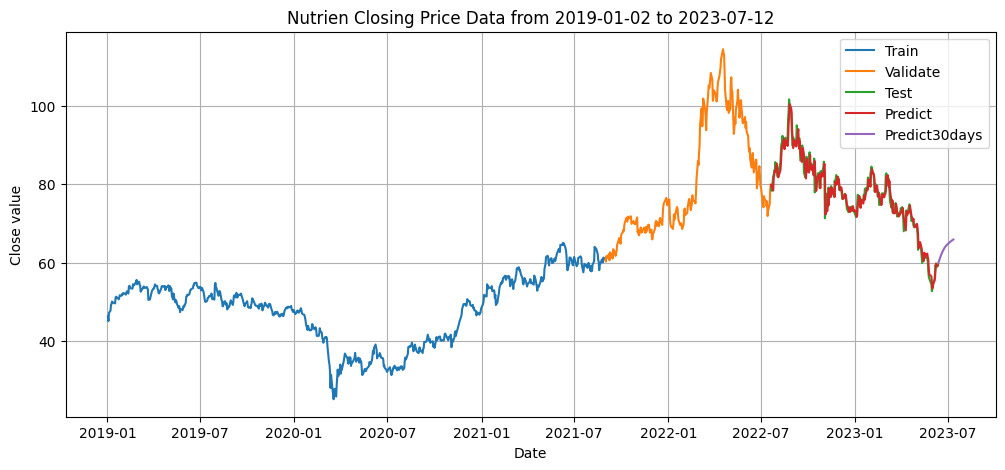

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size : ], loaded_best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_NTR.png')
plt.show()